In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from os.path import join as ospj
from pathlib import Path
import numpy as np
from munch import Munch
from PIL import Image
import time
from torchvision import transforms
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
from core.model import build_nets
from core.checkpoint import CheckpointIO
from functools import wraps

In [4]:
## decorator for time checker
def checkLoggingTime(func):
    @wraps(func)
    def wrapper(*arg, **kwargs):
        start = time.time()
        result = func(*arg, **kwargs)
        end = time.time()
        print("{:.2f}".format(end-start))
        return result
    return wrapper

In [5]:
class Vectorizaiton(object):
    def __init__(self, img_size, target_size, start_size, latent_dim, resume_iter, checkpoint_dir):
        args = Munch()
        args.img_size = img_size
        args.target_size = target_size
        args.start_size = start_size
        args.latent_dim = latent_dim
        args.resume_iter = resume_iter
        args.checkpoint_dir = checkpoint_dir
        self.args = args
        self.nets = build_nets(args)
        

        # below setattrs are to make networks be children of Vetorization, e.g., for self.to(self.device)
        for name, module in self.nets.items():
            # utils.print_network(module, name)
            setattr(self, name, module)
        self.ckptios = [CheckpointIO(ospj(args.checkpoint_dir, '{:06d}_nets.ckpt'), **self.nets)]
        self._load_checkpoint(args.resume_iter)
        self.encoder = self.get_encoder(self.nets)
        print(self.encoder)

    def _load_checkpoint(self, step):
        for ckptio in self.ckptios:
            ckptio.load(step)

    def get_encoder(self, nets):
        return nets.resvae.encoder

    def resize_img(self, imgPath):
        img = Image.open(imgPath)
        mean = [0.5, 0.5, 0.5]
        std = [0.5, 0.5, 0.5]
        transform = transforms.Compose([
                    transforms.Resize([self.args.img_size, self.args.img_size]),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mean, std=std)])
        img = transform(img)
        return img

    def vectorization_one_img(self, imgPath):
        img = self.resize_img(imgPath)
        imgReal = transforms.ToPILImage()(img)
        plt.imshow(imgReal)
        plt.show()
        mu, var = self.encoder(img)
        vector = reparameterization(self.args.latent_dim, mu, var)
        vector = vector.detach().numpy()
        return vector

./expr/checkpoints/top_img/000340_nets.ckpt
Loading Checkpoint from ./expr/checkpoints/top_img/000340_nets.ckpt...
Encoder(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ResBlk(
      (actv): LeakyReLU(negative_slope=0.2)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1x1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResBlk(
      (actv): LeakyReLU(negative_slope=0.2)
      (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1x1): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlk(
      (actv): LeakyReLU(negative_slope=0.2)
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2

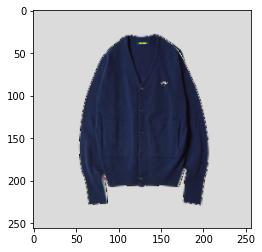

In [6]:
vectorMachine = Vectorizaiton(256, 8, 8, 50, 340, './expr/checkpoints/top_img')
vectorMachine.vectorization_one_img("/workspace/ResVAE-pytorch/data/top/train/1/110100000001.jpg")